# Battle of The Neighborhoods Capstone Project

## Week 3: Segmenting & Clustering Neighborhoods in Toronto

### Author: Firoz Reinders
### Date: 25-12-2019
---

## Introduction
This is the notebook for the Segmentation and Clustering from Week 3 of the Data Science Professional Course Capstone.

## Package Import
The following snippet imports a range of important packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Scraping Wiki and Wrangling the Dataframe

The following section shows how wikipedia is scraped to obtain postal code data in a pandas frame. The table is located at https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. Furthermore, it reshapes and wrangles the dataframe such that it is similar to that provided in the Capstone Week 3 Question Document.

1. The dataframe is read from the tables on the wiki
2. The dataframe is taken from the first table read.
3. Any row with "Borough" value "Not Assigned are dropped by storing the new dataframe (df_grp).
4. The dataframe is grouped by postal code, and all neighbourhoods in the same Borough are joined by comma separation.


In [5]:
#Following snippet reads the table on the wikipedia link and stores it into df_pc.
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" #weblink to the table.

tbls = pd.read_html(link, header=0) #read all tables on the weblink and store in tbls param.
df = tbls[0] #take the postal code dataframe.

df = df[df.Borough != 'Not assigned'] #Drop all boroughs with "Not assigned" labels

df_grp = df.groupby(['Postcode','Borough'])['Neighborhood'].apply(lambda nbhd: ', '.join(nbhd)).reset_index() #group by postcode/borough, then joins the neighbourhoods in that postal code in a single row using commas.    

Next, we iterate over the rows of the dataframe, and assign a "Not assigned" check on the "Neighbourhood" value. Then, if it finds that the neighbourhood is "Not assigned", we replace it with the value of the "Borough".

In [6]:
for ind, row in df_grp.iterrows():
    if row['Neighborhood'] == "Not assigned":
        row["Neighborhood"] == row["Borough"]

In [7]:
df_grp.shape #Show the dimensions (R x C)

(103, 3)

In [8]:
df_grp.head(10) # Shows 10 rows of the dataframe.

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


# Import Additional Packages

In [83]:
#First, we import a range of packages used in the following exercises.

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## Linking Geolocation Data using the Geolocator

In the next section we use the Geocoder location to link the geolocation of the postal codes to the dataframe. However, the code doesn't work properly, so instead we use the CSV file provided in the question document. The code snippets below try using the geolocator. The Geopy package gives the error: "Too May Requests".

Create a copy of the dataframe and add Latitude and Longitude Values. Additionally, loop through the dataframe and add the Latitude and Longitude using the geolocator geocode.

In [10]:
'''#Create new Dataframe and make Latitude and Longitude columns. 
df_ltln = df_grp.copy()
df_ltln['Latitude'] = 0
df_ltln['Longitude'] = 0

geolocator = Nominatim(user_agent="toronto_explorer", timeout=50) # Define Geolocator Agent using Nominatim

# Use a for loop to loop through rows of the dataframe. 
# Then, check the latitude and longitude of the postcode using the geolocator
# Finaly, store the latitude and longitude in their respective columns.
for ind, row in df_ltln.iterrows():
    lat_lng_coords = None #set coordinates to none
    i_pc = row['Postcode']
    while(lat_lng_coords is None):
        lat_lng_coords = geolocator.geocode('{}, Toronto, Ontario'.format(i_pc))
    latitude = lat_lng_coords.latitude
    longitude = lat_lng_coords.longitude
    print('Lat: {}, Long: {}'.format(latitude, longitude))
    row['Latitude'] = latitude
    row['Longitude'] = longitude
    
print(df_ltln.head(5))'''

'#Create new Dataframe and make Latitude and Longitude columns. \ndf_ltln = df_grp.copy()\ndf_ltln[\'Latitude\'] = 0\ndf_ltln[\'Longitude\'] = 0\n\ngeolocator = Nominatim(user_agent="toronto_explorer", timeout=50) # Define Geolocator Agent using Nominatim\n\n# Use a for loop to loop through rows of the dataframe. \n# Then, check the latitude and longitude of the postcode using the geolocator\n# Finaly, store the latitude and longitude in their respective columns.\nfor ind, row in df_ltln.iterrows():\n    lat_lng_coords = None #set coordinates to none\n    i_pc = row[\'Postcode\']\n    while(lat_lng_coords is None):\n        lat_lng_coords = geolocator.geocode(\'{}, Toronto, Ontario\'.format(i_pc))\n    latitude = lat_lng_coords.latitude\n    longitude = lat_lng_coords.longitude\n    print(\'Lat: {}, Long: {}\'.format(latitude, longitude))\n    row[\'Latitude\'] = latitude\n    row[\'Longitude\'] = longitude\n    \nprint(df_ltln.head(5))'

## Linking Geolocation Data using the Provided CSV

The following snippets use the provided CSV (in the assignment) to link the postal codes to the geolocation data. First it makes use of the read_csv function from pandas, and then the merge function. The post(al) codes are used for merging.

In [11]:
link = r'C:\Users\320042528\Desktop\projects\IBM-cap\Geospatial_Coordinates.csv'
df_geoloc = pd.read_csv(link) #reads the CSV file from a local directory and stores it in a dataframe.

df_geoloc.head(5) #gives preview of the read dataframe

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [58]:
df_ll = pd.merge(df_grp, df_geoloc, left_on='Postcode', right_on='Postal Code')
df_ll = df_ll.iloc[:,[3,1,2,4,5]] #rearranges the columns and drops the first one (Postcode) as it is duplicate.
df_ll.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Exploring Toronto

The following snippets of codes will explore Toronto, cluster neighbourhoods and visualize the data using folium. It uses the Geolocator to gain the coordinates of Toronto. These can be used for map visualization.

In [59]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer", timeout=50)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto 43.653963, -79.387207.


In [60]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ll['Latitude'], df_ll['Longitude'], df_ll['Borough'], df_ll['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The following snippet of code defines the foursquare API credentials and version. Then we use foursquare to explore the top 5
venues in a radius of 500 km.

In [61]:
# Define Foursquare Credentials and Version

CLIENT_ID = '3OIXLD5DY2KFRNNBAZZODETQKIEHH1EY5E53BOUAJHWNVI0B' # your Foursquare ID
CLIENT_SECRET = 'H1A4HWQUPRF5SRW4LEO1BQZ0TIAWP3LYTZBUJQP1MTNJSCZ4' # your Foursquare Secret
VERSION = '20161225' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3OIXLD5DY2KFRNNBAZZODETQKIEHH1EY5E53BOUAJHWNVI0B
CLIENT_SECRET:H1A4HWQUPRF5SRW4LEO1BQZ0TIAWP3LYTZBUJQP1MTNJSCZ4


In [122]:
LIMIT = 5 #5 venues max
radius = 500 #radius in m

loc_ven = [] #create an empty list to store the venue locations

for neighborhood, latitude, longitude in zip(df_ll.Neighborhood, df_ll.Latitude, df_ll.Longitude):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
    results = requests.get(url).json()
    
    # use len() to check if any data within "items" (len = 0 if nothing)
    length = len(results['response']['groups'][0]['items'])
    if length == 0:
        continue # skip the row if nothing is found
    else:
        venue = results['response']['groups'][0]['items'][0]['venue']    
        name = venue['name']
        lat = venue['location']['lat']
        lon = venue['location']['lng']
        cat = venue['categories'][0]['name']
        
        loc_ven.append([(neighborhood, latitude, longitude, name, lat, lon, cat)])

Now that we have a list of locations for the top 3 venues within a 500m radius, we transform it into a workable dataframe for pandas.

In [123]:
df_lv = pd.DataFrame(x for row in loc_ven for x in row)
df_lv.columns = ['Neighbourhood','N_Latitude','N_Longitude','Venue','V_Latitude','V_Longitude','category']
df_lv.groupby('category')['Neighbourhood'].nunique() #check the occurence of each category.

category
Airport                          2
Arts & Crafts Store              1
Bakery                           4
Bank                             2
Bar                              2
Baseball Field                   3
Boutique                         1
Breakfast Spot                   1
Brewery                          2
Burger Joint                     1
Cafeteria                        1
Café                             3
Chinese Restaurant               3
Clothing Store                   1
Coffee Shop                      5
Concert Hall                     1
Convenience Store                2
Deli / Bodega                    1
Department Store                 1
Dessert Shop                     1
Diner                            1
Dog Run                          1
Empanada Restaurant              1
Fast Food Restaurant             3
Field                            1
Food                             1
Food & Drink Shop                1
Garden                           1
Gastropub  

Next up is transforming the categories into seperate columns using one-hot encoding. We do this to make it usable for clustering afterwards.

In [124]:
category = pd.get_dummies(df_lv.category) # one hot encoding with get_dummies()
df_ohlv = pd.concat([df_lv[['Neighbourhood']], category], axis=1) # combine neighbourhood & category tables
df_ohlv.head(10)

,Neighbourhood,Airport,Arts & Crafts Store,Bakery,Bank,Bar,Baseball Field,Boutique,Breakfast Spot,Brewery,...,Restaurant,Sandwich Place,Skating Rink,Sports Bar,Supermarket,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Warehouse Store
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Scarborough Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"East Birchmount Park, Ionview, Kennedy Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Clairlea, Golden Mile, Oakridge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Cliffcrest, Cliffside, Scarborough Village West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Birch Cliff, Cliffside West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we start clustering the neighbourhoods based on category, using the previously importent K-Means algorithm from thescikit_learn package. A for loop is used to test different values for K (=number of groups).

C:\Users\320042528\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (59) found smaller than n_clusters (61). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\320042528\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (59) found smaller than n_clusters (71). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\320042528\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (59) found smaller than n_clusters (81). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\320042528\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (59) found smaller than n_clusters (91). Possibly due to duplicate points in X.
  retu

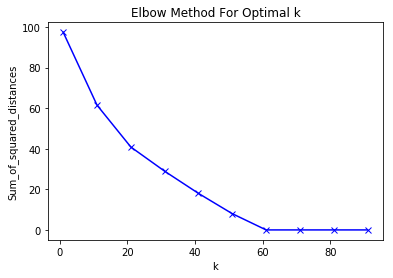

In [125]:
df_kmeans = df_ohlv.drop('Neighbourhood', axis=1) #Drop the neighborhood for clustering reasons. The algorithm won't be able to cluster using categorical strings.

Sum_of_squared_distances = []
K = range(1,100,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_kmeans)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Using the elbow method, we see that the optimal K lies at k=50. However, from a business case perspective, this gives very little insights. In this case, we might prefer a subobtimal clustering level (k < 50). As such, we pick k = 20 to cluster our neighbourhoods. Whereas this lies far below our optimal number of clusters, it makes the data more sensible and readable due to less clusters.

In [129]:
k_pick = 20
clusters = KMeans(n_clusters=k_pick, random_state=0).fit(df_kmeans)

# add the cluster labels to the neighborhoods.
df_labeled = df_ohlv.copy()
df_labeled.insert(1, 'label', clusters.labels_)

df_labeled.head(10)

,Neighbourhood,label,Airport,Arts & Crafts Store,Bakery,Bank,Bar,Baseball Field,Boutique,Breakfast Spot,...,Restaurant,Sandwich Place,Skating Rink,Sports Bar,Supermarket,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Warehouse Store
0,"Rouge, Malvern",18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Woburn,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Scarborough Village,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"East Birchmount Park, Ionview, Kennedy Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Clairlea, Golden Mile, Oakridge",18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Cliffcrest, Cliffside, Scarborough Village West",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Birch Cliff, Cliffside West",5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
df_clustMerg = pd.merge(df_ll, df_labeled, right_on='Neighbourhood', left_on='Neighborhood', how='right')
df_clustMerg.head(10)

,Postal Code,Borough,Neighborhood_x,Latitude,Longitude,Neighbourhood,label,Airport,Arts & Crafts Store,Bakery,...,Restaurant,Sandwich Place,Skating Rink,Sports Bar,Supermarket,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Warehouse Store
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,"Rouge, Malvern",18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,"Guildwood, Morningside, West Hill",3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,Woburn,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Cedarbrae,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,Scarborough Village,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,"East Birchmount Park, Ionview, Kennedy Park",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,"Clairlea, Golden Mile, Oakridge",18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,"Cliffcrest, Cliffside, Scarborough Village West",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,"Birch Cliff, Cliffside West",5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Once more, a map is created. This time we use the 20 clusters defined above.

In [131]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k_pick)
ys = [i + x + (i*x)**2 for i in range(k_pick)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustMerg['Latitude'], df_clustMerg['Longitude'], df_clustMerg['Neighbourhood'], df_clustMerg['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Summary

In this notebook we've seen a visualization of clusters of Neigbourhoods in Toronto by nearby top amenities / venues.

1. We've taken a table with postal codes, neigbourhoods and boroughs from Wikipedia.
2. We've linked it to latitude and longitude information using a provided data file.
3. We've used the Foursquare API to retreive venue information based on that location data.
4. We've used the K-means algorithm to cluster neighbourhoods based on nearby amenities.
5. We've visualized our data using Folium maps.

This document is used for educational and practice purposes purely. Please regards it as such.

### End of this Notebook